# 1.Supervised mosaic integration using full annotation with Palette

In addition to unsupervised integration, **Palette** supports a supervised mode where cell type labels are incorporated to guide subspace learning and improve alignment of biologically meaningful structures across batches and modalities. 

In this tutorial, we applied Palette on human BMMC CITE-seq and 10x Multiome data from the [NeurIPS 2021 single-cell multimodal data benchmark](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE194122). For two technologies, 3 batches are selected for integration, respectively.

In [1]:
library(PaletteSC)
library(uwot)
library(cowplot)
library(RColorBrewer)
library(ggplot2)
library(RColorBrewer)
library(scattermore)
library(ggsci)

Loading required package: Matrix



## Load data and metadata

We read in the datasets, with rows as features and columns as cells for all modalities. The highly variable features (HVFs) are already selected and are used to perform integration. For the scRNA-seq data, highly variable genes (HVGs) were identified independently for each batch using FindVariableFeatures and taking the union of HVGs across batches. For scATAC-seq data, we remove the peaks on the sex chromosomes to ensure that the data is an appropriate input for any algorithm. It is worth mentioning that the Palette algorithm does not inherently require the removal of the peaks on the sex chromosomes. For ADT data, we kept all features as input.

In [2]:
options(future.globals.maxSize = 50 * 1024^3)
setwd('../')
path1 <- c('./CITE/s1d1_cite','./CITE/s1d2_cite','./CITE/s1d3_cite')
rna1.list <- list()
adt.list <- list()
for(i in 1:3){
  rna1.list[[i]] <- readRDS(paste0(path1[i],'/rna.rds'))
  adt.list[[i]] <- readRDS(paste0(path1[i],'/adt.rds'))
}
path2 <- c('./Multiome/s1d1_multi','./Multiome/s1d2_multi','./Multiome/s1d3_multi')
rna2.list <- list()
atac.list <- list()
for(i in 1:3){
  rna2.list[[i]] <- readRDS(paste0(path2[i],'/rna.rds'))
  atac.list[[i]] <- readRDS(paste0(path2[i],'/atac.rds'))
}
meta <- readRDS('./meta.rds')
meta <- meta[,c(1,2,4)]
colnames(meta) <- c('Batch','CellType','Modality')
head(meta)

,Batch,CellType,Modality
,<chr>,<chr>,<chr>
GCATTAGCATAAGCGG-1-s1d1,CITE1,Naive CD20+ B,CITE-seq
TACAGGTGTTAGAGTA-1-s1d1,CITE1,CD14+ Mono,CITE-seq
AGGATCTAGGTCTACT-1-s1d1,CITE1,Naive CD20+ B,CITE-seq
GTAGAAAGTGACACAG-1-s1d1,CITE1,HSC,CITE-seq
TCCGAAAAGGATCATA-1-s1d1,CITE1,Reticulocyte,CITE-seq
CTCCCAATCCATTGGA-1-s1d1,CITE1,Normoblast,CITE-seq


## Create a Palette object and add cell type labels information

The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for multimodal dataset.

**Palette** accepts data in **list format**, with each element representing a feature-by-cell data matrix. The modality and batch information for each input are provided through ```modals``` and ```samples```.

The cell type annotation information of the data is placed in the ```Meta``` slot as a priori guidance information for supervised integration.

In [3]:
obj <- Create.Palette.Object(data.list = c(rna1.list,
                                             rna2.list,
                                             adt.list,
                                             atac.list), 
                               samples = c('CITE1','CITE2','CITE3',
                                           'Multiome1','Multiome2','Multiome3',
                                           'CITE1','CITE2','CITE3',
                                           'Multiome1','Multiome2','Multiome3'), 
                               modals = c("rna","rna","rna",
                                          "rna","rna","rna",
                                          "adt",'adt','adt',
                                          "atac","atac","atac"))

all.equal(obj@Meta$cell.name,rownames(meta))
obj@Meta[['celltype']] <- meta$CellType

rm(rna1.list,rna2.list,adt.list,atac.list)

[1] TRUE

## Data preprocessing

For the scRNA-seq data, we performed standard log-normalization using the NormalizeData function from the Seurat R package. For the scATAC-seq data, we performed inverse document frequency (IDF)–based scaling followed by log normalization on the peak count matrix. And for the ADT data, we performed centered log ratio transformation.

In [4]:
obj <- Normalize.Data(obj,modal = "rna",normal.method = "LogNormalize")
obj <- Normalize.Data(obj,modal = "adt",normal.method = "CLR",margin = 2)
obj <- IDFLog.Data(obj,modal = "atac")

obj <- Add.HVFs(obj, modal = "rna")
obj <- Add.HVFs(obj, modal = "adt")
obj <- Add.HVFs(obj, modal = "atac")

Performing IDF and log normalization

No features provide, use all shared features by default.

No features provide, use all shared features by default.

No features provide, use all shared features by default.



## Sample representative cells

In the supervised setting, cell type annotations are available. **Palette** selects a subset of representative cells from each batch. Specifically, silhouette widths (SWs) are computed for all cells based on their cell type assignments. Within each cell type, cells are ranked by their SW values, and the top 25% (by default) are selected. By sampling representative cells, **Palette** is more robust to the potentially mislabeled cell annotation and is more computationally effective than using all cells in subsequent calculations.

In ```DownSample``` function, ```supervised``` controls whether to perform supervised downsampling using predefined groups. If ```supervised=TRUE```, metadata column name should be specified using ```group```. If ```supervised=FALSE```, ensure that the data already has clustering information.

In [5]:
obj <- DownSample(obj,modal = c('rna','adt','atac'),
                  supervised = TRUE,
                  group = 'celltype',
                  method = c("PCA","PCA","LSI"))

## Intra-modal joint dimensionality reduction using Bi-sPCA

**Palette** independently integrating each data modality across batches using **Bi-supervised Principal Component Analysis (Bi-sPCA)**, a new dimensionality reduction model aiming to disentangle biological signals from technical effects. **Bi-sPCA** operates on kernel representations of both biological and technical variation, learning a projection that maximizes biological variation in the embedding while minimizing unwanted technical effects.

```lambda``` balances the relative importance of biological effect and batch effect. If there are strong batch effects between batches, we recommend using a higher ```lambda``` value. To ensure numerical stability, **Palette** restricts 𝜆 to the range `[0,1)`.

In the supervised integration scenario, **Palette** constructs the biological kernel matrix based on prior information. In this case, there is no need to set parameters such as ```joint```, ```max.Angle```, and ```Angle.var``` that are required in the unsupervised scenario.

To alleviate the computational burden of applying **Bi-sPCA** to datasets with extremely high feature dimensionality, such as scATAC-seq data, **Palette** incorporates two pre-dimensionality reduction strategies. If the matrix dimension exceeds ```RP_thresh```, pre-dimensionality reduction will be performed. ```pre.reduce``` controls whether to perform LSI (SVD) before **Bi-sPCA**. If ```pre.reduce=FALSE```, the random projection (RP) algorithm is used for pre-dimensionality reduction. For large-scale data, LSI pre-dimensionality reduction has higher computational efficiency than RP pre-dimensionality reduction.

In [6]:
obj <- Find.Subspace(obj,modal = c("rna",'adt','atac'),
                     lambda = list(0.8,0.8,0.5),
                     supervised = TRUE,
                     sub.dims = list(1:40,1:30,1:30),
                     pre.reduce = FALSE,
                     RP_thresh = 10000)

Performing random projection on modal atac. 




## MBG-guided inferring of missing modality matrices and Cross-batch alignment

**Palette** constructs a **mosaic bipartite graph (MBG)** to capture the structural topology of data. The **MBG** is an undirected, unweighted, and connected bipartite graph where nodes represent batches and modalities, and edges indicate the presence of a given modality in a batch. This graph sequentially connects the partially overlapping modalities across batches. For batches that lack measurements in specific modalities, **Palette** identifies shortest paths in the **MBG** that connect the batch to the missing modality. These paths define biologically informed propagation routes across the latent spaces of the shared modalities, enabling inference of low-dimensional representations for unobserved modalities by transferring information through matched neighbors across batches. **Palette** employs multiple paths to infer the missing data for each cell in a weighted approach. Finally, both real and inferred representations of all batches are jointly embedded into a unified low-dimensional space using **Bi-sPCA** again.

In the supervised integration scenario, **Palette** uses prior information labels to further filter the connections in the biological kernel matrix. Here, we use ```supervised = TRUE``` to specify the supervised integration mode and use ```group``` to specify the metadata column name, same as ```DownSample``` function.

In [7]:
obj <- Run.Palette(obj,supervised = TRUE,group = 'celltype')

Constructing MBG.

MBG Done!

Inferring missing modality matrices guided by MBG.


Performing inference for modal "atac" of  sample "CITE1" in embedding space.


Performing inference for modal "atac" of  sample "CITE2" in embedding space.


Performing inference for modal "atac" of  sample "CITE3" in embedding space.


Performing inference for modal "adt" of  sample "Multiome1" in embedding space.


Performing inference for modal "adt" of  sample "Multiome2" in embedding space.


Performing inference for modal "adt" of  sample "Multiome3" in embedding space.


MBG-guided inferring Done.


Cross-batch alignment.


Palette integration Done! 




## Visualization

In [8]:
Palette_emb <- as.matrix(obj@Int.result[["bind"]][rownames(meta),])
Palette_umap = as.data.frame(umap(Palette_emb))
colnames(Palette_umap) = c("UMAP1", "UMAP2")
Palette_umap = cbind.data.frame(meta, Palette_umap)
fig.size = function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”


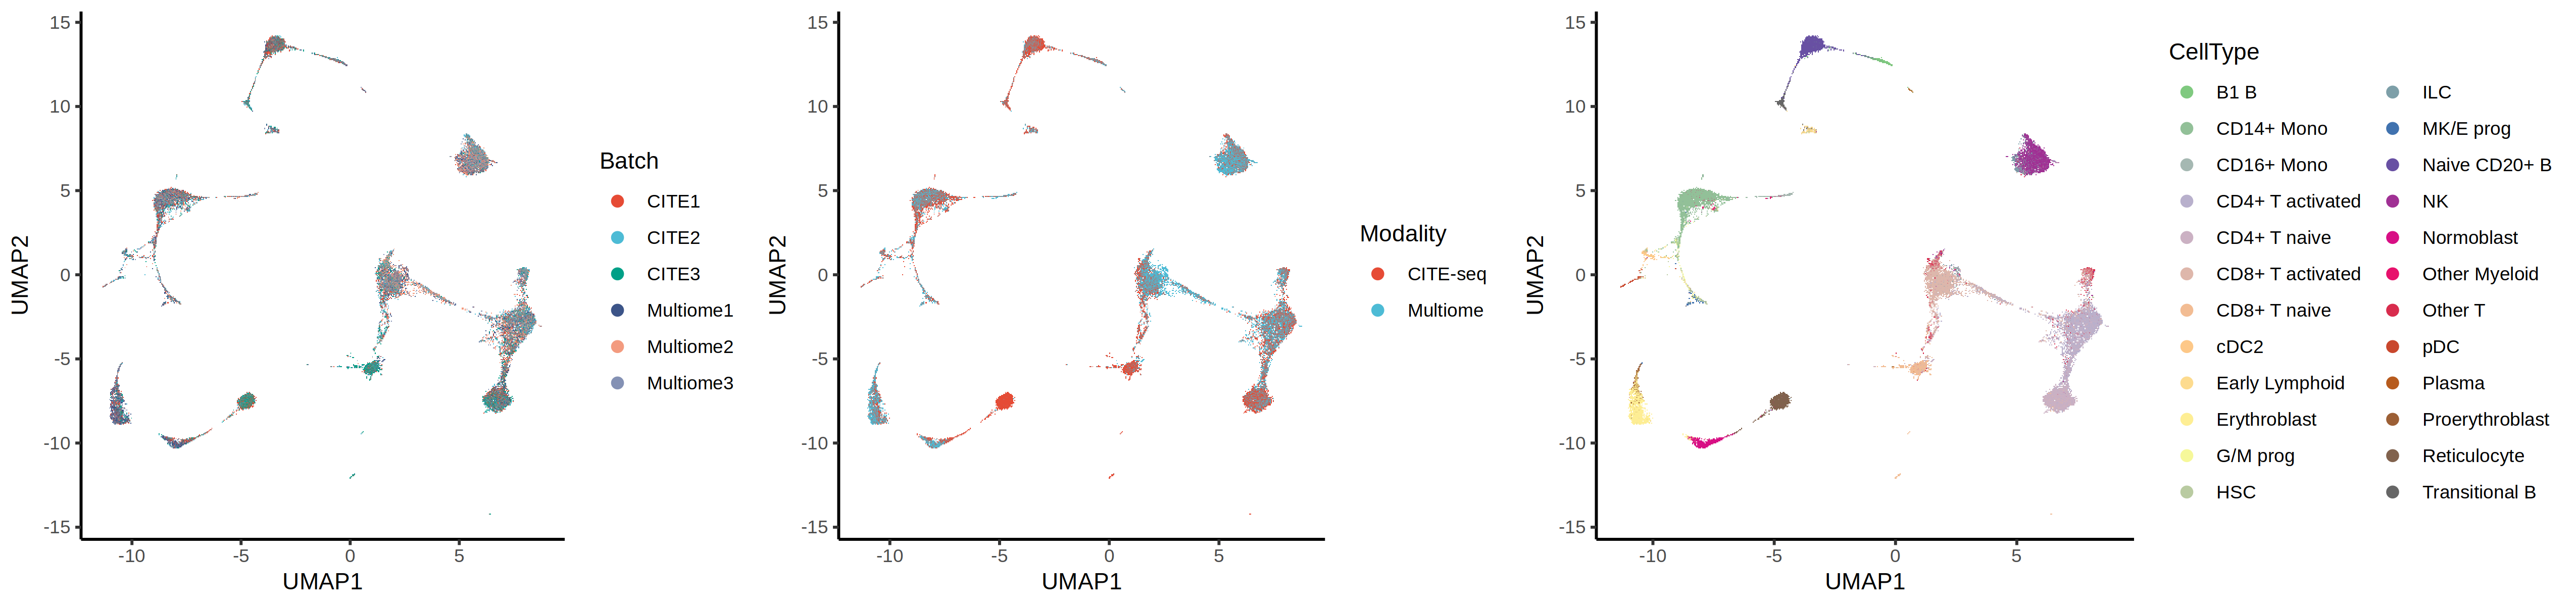

In [9]:
p1 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Batch)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

p2 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Modality)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")


Colors <- colorRampPalette(brewer.pal(12, "Accent"))(24)

p3 <- ggplot(Palette_umap, aes(x = UMAP1, y = UMAP2, color = CellType)) +
  geom_scattermore(pointsize = 1) +   
  scale_color_manual(values = Colors) +  
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic() +
  theme(legend.position = "right")

fig.size(4,17)
plot_grid(p1, p2, p3,align = 'h', axis = "b",nrow = 1,rel_widths = c(5,5,7))

## Save results

In [10]:
out_dir <- '../'
write.csv(Palette_emb,
          paste0(out_dir,'/Palette_res_supervised.csv'),
          row.names = FALSE)

# 2.Supervised mosaic integration with partially missing cell type labels using Palette.

In practical applications, cell type annotations are often incomplete, with labels missing for a subset of cells. `Palette` is designed to support supervised integration under such partially labeled settings.

To demonstrate this scenario, we randomly mask the cell type labels of **20%** of cells in the metadata by setting them to `NA`, and then provide the partially labeled dataset as input to Palette for integration.

## Add cell type labels information

In [11]:
meta$Label_mod <- meta$CellType
sample_size <- ceiling(0.2 * nrow(meta))
set.seed(123)
idx <- sample(1:nrow(meta), sample_size,replace = F)
meta$Label_mod[idx] <- NA

## Run Palette

In [12]:
all.equal(obj@Meta$cell.name,rownames(meta))
obj@Meta[['celltype']] <- meta$Label_mod

obj <- DownSample(obj,modal = c('rna','adt','atac'),
                  supervised = TRUE,
                  group = 'celltype',
                  method = c("PCA","PCA","LSI"))

obj <- Find.Subspace(obj,modal = c("rna",'adt','atac'),
                     lambda = list(0.8,0.8,0.5),
                     supervised = TRUE,
                     sub.dims = list(1:40,1:30,1:30),
                     pre.reduce = FALSE,
                     RP_thresh = 10000)

obj <- Run.Palette(obj,supervised = TRUE,group = 'celltype')

[1] TRUE

Performing random projection on modal atac. 


Constructing MBG.

MBG Done!

Inferring missing modality matrices guided by MBG.


Performing inference for modal "atac" of  sample "CITE1" in embedding space.


Performing inference for modal "atac" of  sample "CITE2" in embedding space.


Performing inference for modal "atac" of  sample "CITE3" in embedding space.


Performing inference for modal "adt" of  sample "Multiome1" in embedding space.


Performing inference for modal "adt" of  sample "Multiome2" in embedding space.


Performing inference for modal "adt" of  sample "Multiome3" in embedding space.


MBG-guided inferring Done.


Cross-batch alignment.


Palette integration Done! 




## Visualization

Warning message in brewer.pal(12, "Accent"):
“n too large, allowed maximum for palette Accent is 8
Returning the palette you asked for with that many colors
”


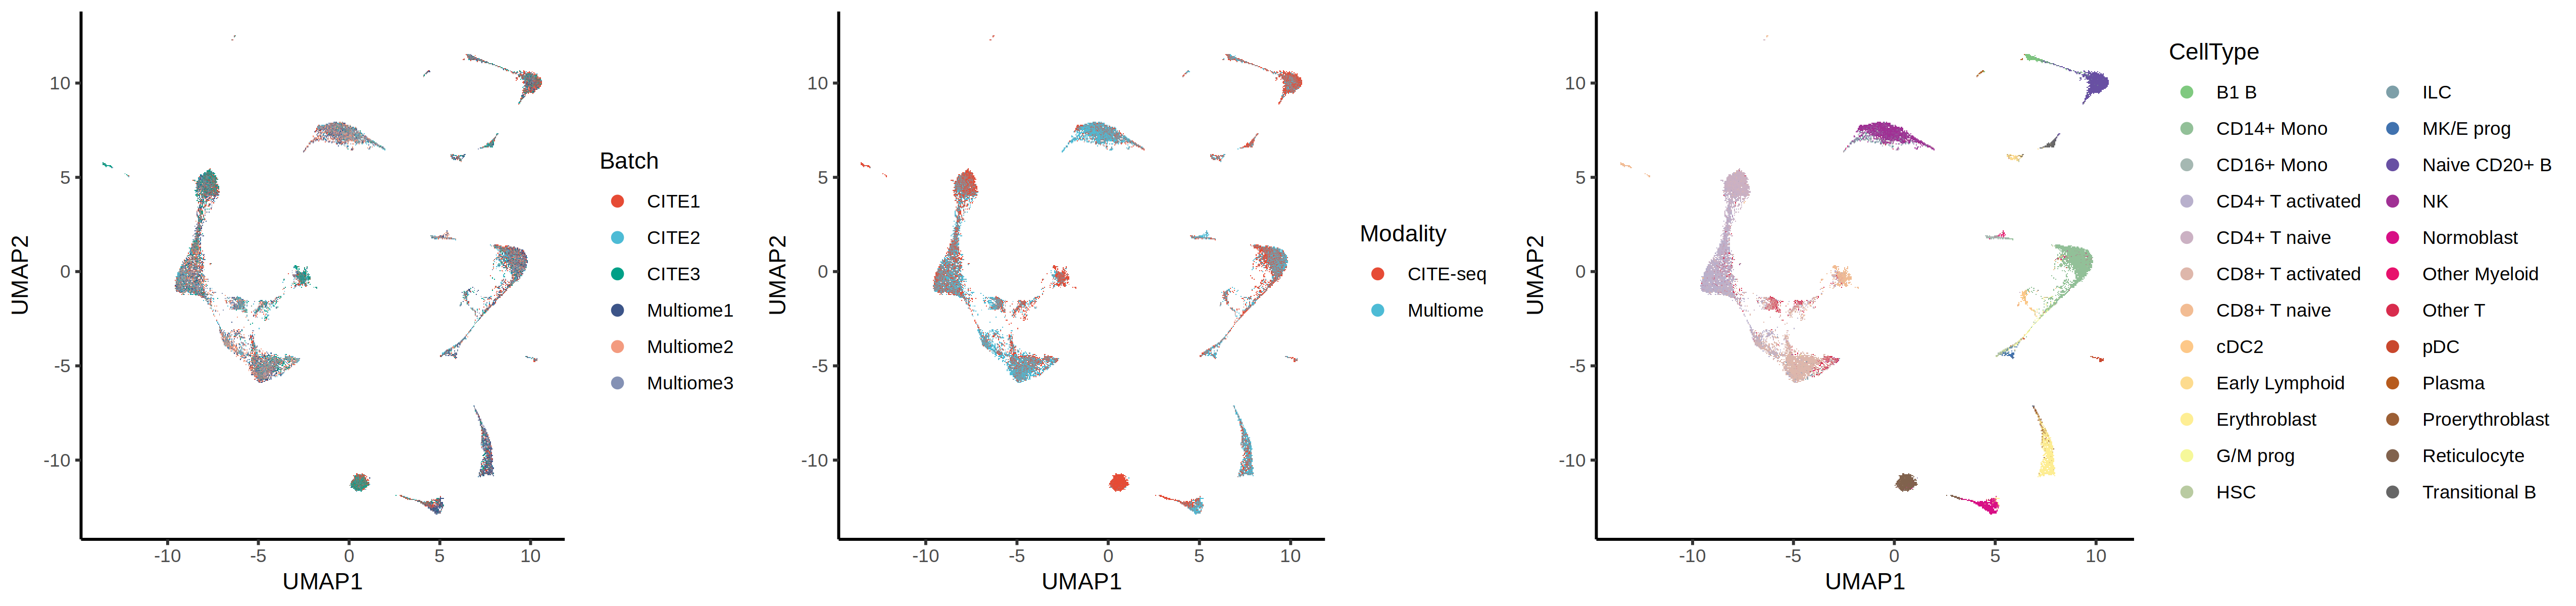

In [13]:
Palette_emb <- as.matrix(obj@Int.result[["bind"]][rownames(meta),])
Palette_umap = as.data.frame(umap(Palette_emb))
colnames(Palette_umap) = c("UMAP1", "UMAP2")
Palette_umap = cbind.data.frame(meta, Palette_umap)
fig.size = function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 300)
}

p1 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Batch)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")

p2 <- ggplot(Palette_umap, aes(UMAP1, UMAP2, color = Modality)) +
  geom_scattermore(pointsize = 1) +
  scale_color_npg() +
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic()+
  theme(legend.position = "right")


Colors <- colorRampPalette(brewer.pal(12, "Accent"))(24)

p3 <- ggplot(Palette_umap, aes(x = UMAP1, y = UMAP2, color = CellType)) +
  geom_scattermore(pointsize = 1) +   
  scale_color_manual(values = Colors) +  
  guides(colour = guide_legend(override.aes = list(size = 2))) +
  theme_classic() +
  theme(legend.position = "right")

fig.size(4,17)
plot_grid(p1, p2, p3,align = 'h', axis = "b",nrow = 1,rel_widths = c(5,5,7))

## Session Info

In [14]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/sqy/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggsci_3.0.3        scattermore_1.2    ggplot2_3.5.1      RColorBrewer_1.1-3
[5] cowplot_1.1.3      uwot_0.2.2         Matrix_1.6-5       PaletteSC_0.1.0   

loaded via a namespace (and not attached):
  [1] Seurat_4.4.0           Rtsne_0.17             colorspace_2.1-1      
  [4] deldir_2.0-4           ggridg